# EFM Holdings Dashboard

## 1. Set up environment

In [9]:
# Set up environment - import libraries, set options, define paths, filenames, import files

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from efm_functions import *
import os
from copy import deepcopy
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Set options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 130)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Import files

In [10]:
# Define file paths and file names, import files
data_path = "Data/"
output_path = "Data/Output/"
bbg_path = "Data/bbg_historical_holdings/dm_sectors/"
crd_path = 'Data/crd_daily_holdings_new/'

efm_dict = {'MOMG':'BlackRock US MF',
            'MOMN':'Dimensional US MF',
            'MOMP':'Invesco US MF', 
            'MOMS':'Acadian US Value',
            'MOMU':'AB US Growth',
            'MOMX':'BlackRock EU Systematic'}

# Import Data

"""
efm_holdings_data
"""
# "efm_holdings_data" will consist of dataframes from "df_list" which will be a list of DataFrames for each manager   
df_list = []
    
for filename in os.listdir(crd_path):
    df = pd.read_csv(crd_path + filename)
    
    df['Effective Date'] = pd.to_datetime(df['Effective Date'])
    df = df.sort_values(by='Effective Date')
    
    if filename == 'momp_si_20230605.csv':
        df = df[df['Effective Date'] >= '2022-02-11']
        
    elif filename == 'momu_si_20230605.csv':
        df = df[df['Effective Date'] >= '2022-12-21']
        
    elif filename == 'momx_si_20230605.csv':
        df = df[df['Effective Date'] >= '2022-12-30']
        
    elif filename == 'momg_si_20230605.csv':
        df = df[df['Effective Date'] >= '2021-12-01']
    
    df_list.append(df)

# "efm_holdings_data" will be a DataFrame (df) containing historical stock holdings of efms defined above, and will be saved as defined below as .csv
efm_holdings_data = pd.concat(df_list).set_index('Effective Date')
efm_holdings_data.index = pd.to_datetime(efm_holdings_data.index)
efm_holdings_data['SEDOL'] = efm_holdings_data['SEDOL'].astype(str)

# Save holdings data as csv file with the output being named with today's date
save_csv(efm_holdings_data, output_path, 'efm_holdings_data')


"""
stock_data
"""
# "stock_data" will contain stock data of MSCI and US and Europe as defined below
stock_data = pd.read_excel(data_path + 'MXUS EU as of Mar 24 20231.xlsx')
stock_data['SEDOL'] = stock_data['SEDOL'].astype(str)


"""
bbg_data
"""
# "bbg_data" contains stock holdings of EFMs from the PORT function on Bloomberg which only contains weekly data up to the past 40 weeks
bbg_df_list = []

# Loop through all the Excel files in the folder
for filename in os.listdir(bbg_path):
    df = pd.read_excel(bbg_path + filename)
    bbg_df_list.append(df)

# "bbg_data" will contain historical stock holdings from bloomberg
bbg_data = pd.concat(bbg_df_list)

# Save holdings data as csv file with the output being named with today's date
# save_csv(bbg_data, output_path, 'bbg_holdings_data')
print('Files successfully imported.')

Files successfully imported.


In [11]:
efm_holdings_data

,Account Code,Ticker,SEDOL,Security ID,Sec Name,Long/Short,Quantity,Market Value,Accrued Int,Exposure Amt,Currency Cd
Effective Date,,,,,,,,,,,
2021-12-01,MOMG,A,2520153,19826047,AGILENT TECHNOLOGIES INC COMMON STOCK USD.01,L,"5,911.00","876,069.31",NaN,NaN,USD
2021-12-01,MOMG,SBUX,2842255,19827225,STARBUCKS CORP COMMON STOCK USD.001,L,"1,951.00","211,995.66",NaN,NaN,USD
2021-12-01,MOMG,BIIB,2455965,19826244,BIOGEN INC COMMON STOCK USD.0005,L,953.00,"218,713.50",NaN,NaN,USD
2021-12-01,MOMG,EXC,2670519,19826558,EXELON CORP COMMON STOCK,L,"19,794.00","1,035,028.26",NaN,NaN,USD
2021-12-01,MOMG,SLB,2779201,19827271,SCHLUMBERGER LTD COMMON STOCK USD.01,L,"19,883.00","564,279.54",NaN,NaN,USD
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,MOMX,SAP,4846288,19827216,SAP SE COMMON STOCK,L,"5,842.00","719,033.36",NaN,NaN,EUR
2023-06-05,MOMX,SBMO,B156T57,74383352,SBM OFFSHORE NV COMMON STOCK EUR.25,L,720.00,"9,547.20",NaN,NaN,EUR
2023-06-05,MOMX,DNLM,B1CKQ73,74383355,DUNELM GROUP PLC COMMON STOCK GBP.01,L,"2,102.00","27,566.60",NaN,NaN,EUR


## 3. Process Data

In [3]:
# Merge efm_holdings_data with stock_data to update holdings data with sector and subinudstry data from stock_data
holdings_merged_1 = pd.merge(efm_holdings_data, stock_data, on='SEDOL', how='left')
holdings_merged_1.index = efm_holdings_data.index

# Count proportion of empty sectors
holdings_merged_1['Sector'].isnull().sum() / len(holdings_merged_1)

"""
bbg_processed
"""

# Process the bloomberg data to tag the sector names, as the data is separated by sector rows and does not have sector column
bbg_processed_list = []

for bbg_df in bbg_df_list:
    df1 = bbg_df.copy()
    df1 = df1.loc[:, ['Name', 'SEDOL1', 'ISIN', 'Ticker']]
    
    # find the index of the separator rows
    sector_indexes = df1[df1['Name'].str.startswith('›')].index.tolist()
    df2 = df1[~df1['Name'].str.startswith('›')]
    df2 = df2.drop(index=0)
    
    # create a list of sectors
    sectors = []
    for i in range(len(sector_indexes)):
        start = sector_indexes[i]
        if i == len(sector_indexes) - 1:
            end = len(df1)
        else:
            end = sector_indexes[i+1]
        sector_name = df1.iloc[start]['Name'][2:]
        sectors.extend([sector_name] * (end - start - 1))
    
    # add the "Sector" column to the dataframe
    df2['Sector'] = sectors
    bbg_processed_list.append(df2)
    
bbg_processed = pd.concat(bbg_processed_list)
bbg_processed = bbg_processed.rename(columns={'SEDOL1': 'SEDOL'})
bbg_processed['SEDOL'] = bbg_processed['SEDOL'].astype(str)
save_csv(bbg_processed, output_path, 'bbg_processed')

# Merge the dataframes to obtain sector and subinudstry data
bbg_processed.drop_duplicates(subset=['SEDOL'], inplace=True)
holdings_merged_2 = pd.merge(holdings_merged_1, bbg_processed, on='SEDOL', how='left')
holdings_merged_2.index = holdings_merged_1.index
holdings_merged_2['Sector_x'] = holdings_merged_2['Sector_x'].fillna(holdings_merged_2['Sector_y'])
holdings_merged_2 = holdings_merged_2.drop('Sector_y', axis=1)
holdings_merged_2 = holdings_merged_2.rename(columns={'Sector_x': 'Sector'})
holdings = holdings_merged_2
save_csv(holdings, output_path, 'holdings')

# Count proportion of empty sectors
proportion = holdings['Sector'].isnull().sum() / len(holdings)

# Replace NaN values in the 'Sector' column with 'Not Classified'
holdings['Sector'].fillna('Null', inplace=True)

# Convert values in the 'Market Value' column to negative floats if they are enclosed in parentheses
holdings['Market Value'] = holdings['Market Value'].str.replace(',', '').str.replace('(', '-', regex=False).str.replace(')', '', regex=False).astype(float)
holdings['Quantity'] = holdings['Quantity'].str.replace(',', '').str.replace('(', '-', regex=False).str.replace(')', '', regex=False).astype(float)

# Display information on processed data
fund_list = list(holdings['Account Code'].unique())
latest_date = holdings.index.max()
number_of_rows = len(holdings)
print(f'Funds: {fund_list} \n'
      f'Latest date: {latest_date:"%Y-%m-%d"} \n'
      f'Missing sectors: {proportion:.2%} \n'
      f'{number_of_rows} rows')

Funds: ['MOMG', 'MOMN', 'MOMP', 'MOMS', 'MOMU', 'MOMX'] 
Latest date: "2023-06-06" 
Missing sectors: 1.68% 
341805 rows


In [4]:
# find the index of the separator rows
df1 = pd.read_excel('Data/bbg_dm_industry_group.xlsx')

industry_group_indexes = df1[df1['Name'].str.startswith('›')].index.tolist()
df2 = df1[~df1['Name'].str.startswith('›')]
df2 = df2.drop(index=0)

# create a list of sectors
industry_groups = []
for i in range(len(industry_group_indexes)):
    start = industry_group_indexes[i]
    if i == len(industry_group_indexes) - 1:
        end = len(df1)
    else:
        end = industry_group_indexes[i+1]
    ig_name = df1.iloc[start]['Name'][2:]
    industry_groups.extend([ig_name] * (end - start - 1))

# add the "Sector" column to the dataframe
df2['Industry Group'] = industry_groups
    
df2 = df2.rename(columns={'SEDOL1': 'SEDOL'})
df2['SEDOL'] = df2['SEDOL'].astype(str)
save_csv(df2, output_path, 'df2')

# Merge the dataframes to obtain sector and subinudstry data
df2.drop_duplicates(subset=['SEDOL'], inplace=True)
holdings_merged_2 = pd.merge(holdings, df2, on='SEDOL', how='left')
holdings_merged_2.index = holdings.index
holdings = holdings_merged_2

# Replace NaN values in the 'Sector' column with 'Not Classified'
holdings['Sector'].fillna('Null', inplace=True)

# Display information on processed data
fund_list = list(holdings['Account Code'].unique())
latest_date = holdings.index.max()
number_of_rows = len(holdings)
print(f'Funds: {fund_list} \n'
      f'Latest date: {latest_date:"%Y-%m-%d"} \n'
      f'Missing sectors: {proportion:.2%} \n'
      f'{number_of_rows} rows')

Funds: ['MOMG', 'MOMN', 'MOMP', 'MOMS', 'MOMU', 'MOMX'] 
Latest date: "2023-06-06" 
Missing sectors: 1.68% 
341805 rows


C:\Users\intern.yoongsiew\AppData\Local\Temp\ipykernel_13340\2690898789.py:28: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Ticker_x'} in the result is deprecated and will raise a MergeError in a future version.
  holdings_merged_2 = pd.merge(holdings, df2, on='SEDOL', how='left')


In [5]:
holdings.to_csv('holdings_industry_group.csv')

## 4. Calculate and plot sector weights over time

In [6]:
industry_weights_df = industry_group_weights(holdings)

In [7]:
industry_weights_df

,Account Code,Industry Group,Industry Group Weight
Effective Date,,,
2021-12-01,MOMG,Automobiles & Components,0.035979
2021-12-01,MOMG,Banks,0.034762
2021-12-01,MOMG,Capital Goods,0.010713
2021-12-01,MOMG,Commercial & Professional Services,0.020108
2021-12-01,MOMG,Consumer Discretionary Distribution & Retail,0.044472
...,...,...,...
2023-06-06,MOMP,Software & Services,0.083489
2023-06-06,MOMP,Technology Hardware & Equipment,0.074364
2023-06-06,MOMP,Telecommunication Services,0.006327


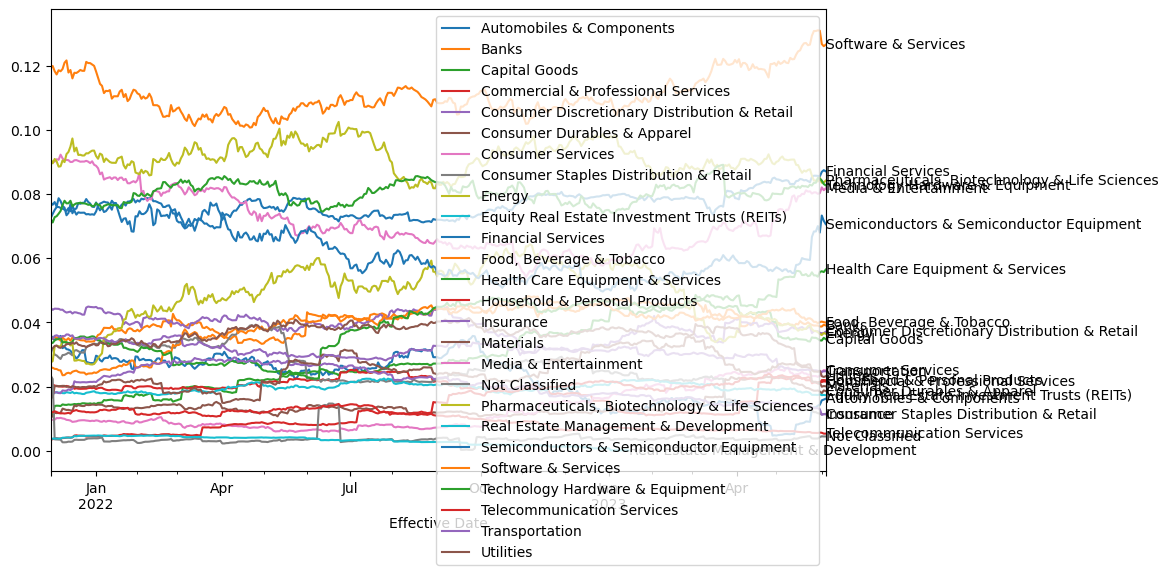

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


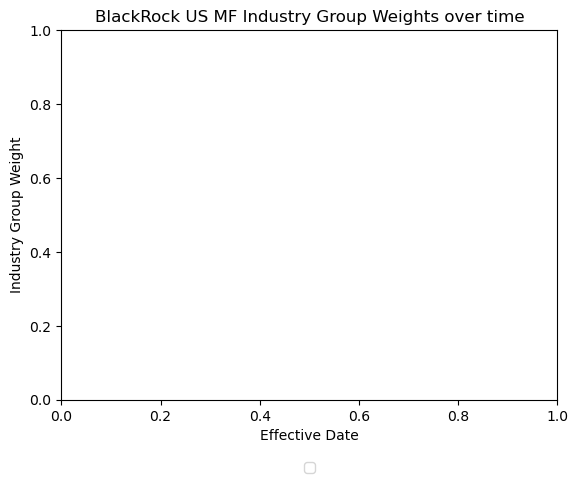

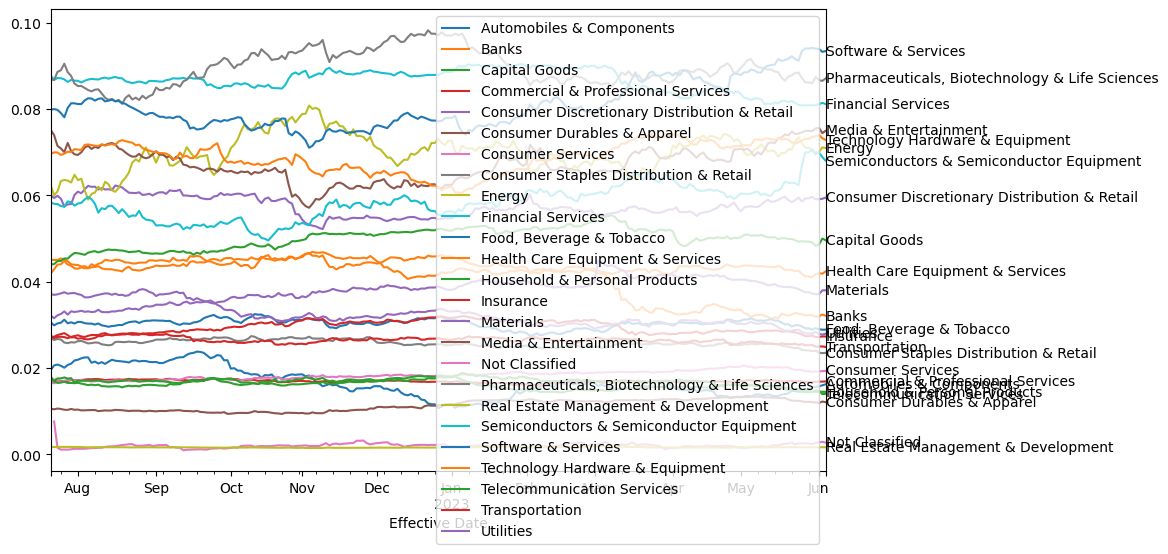

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


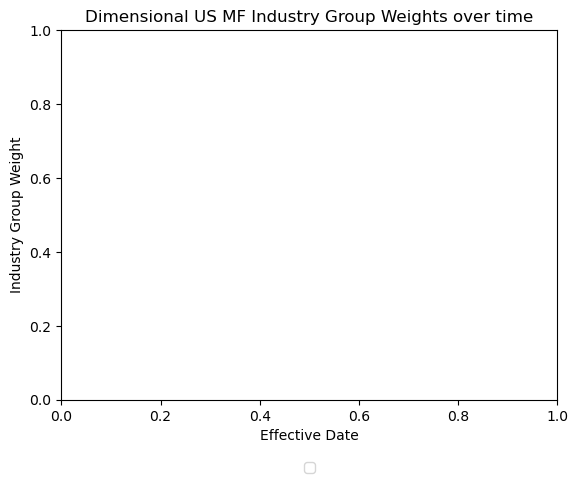

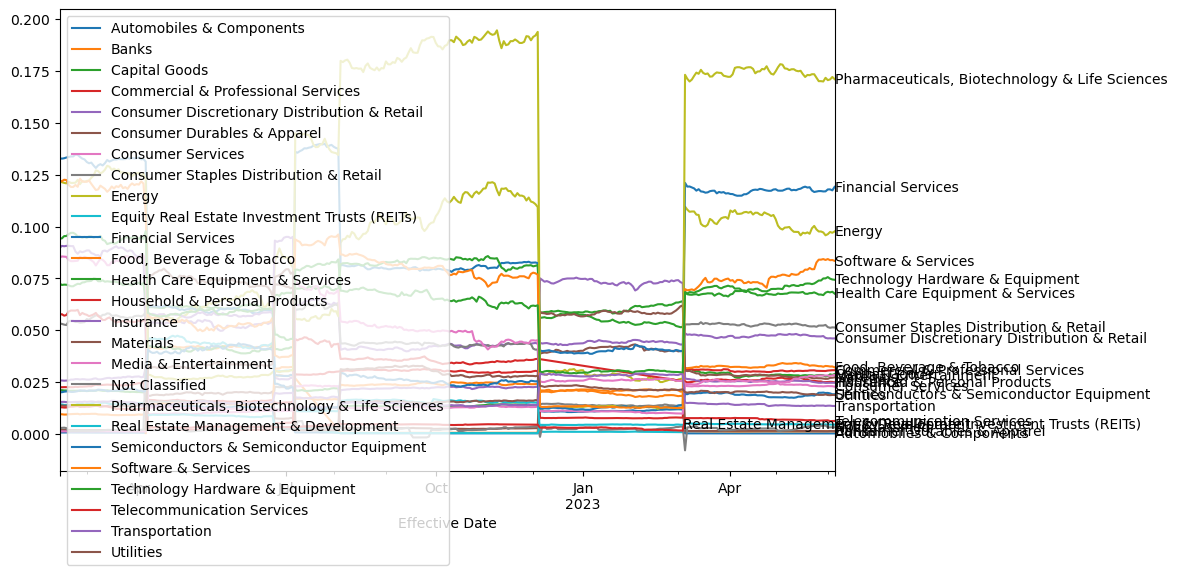

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


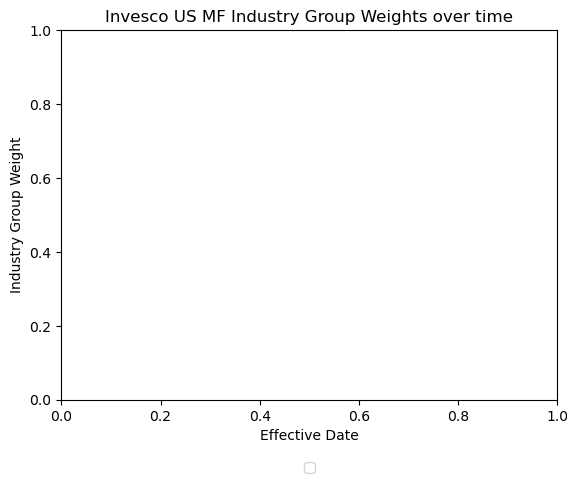

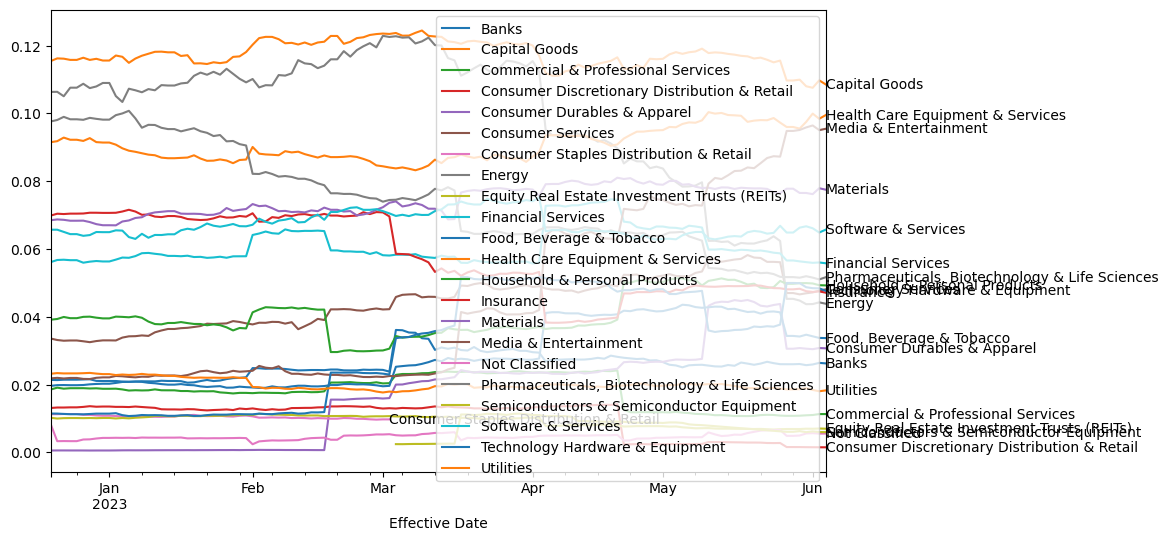

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


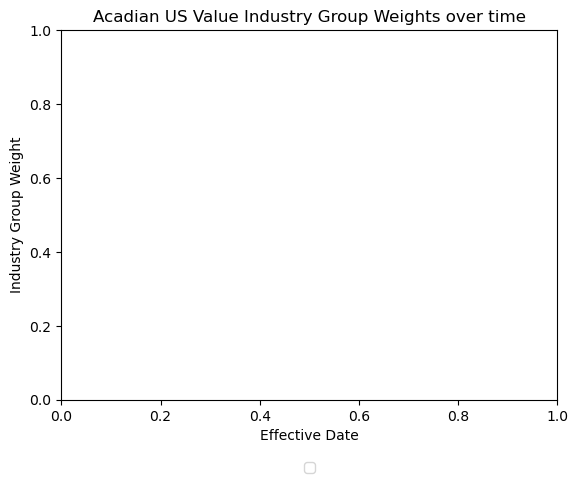

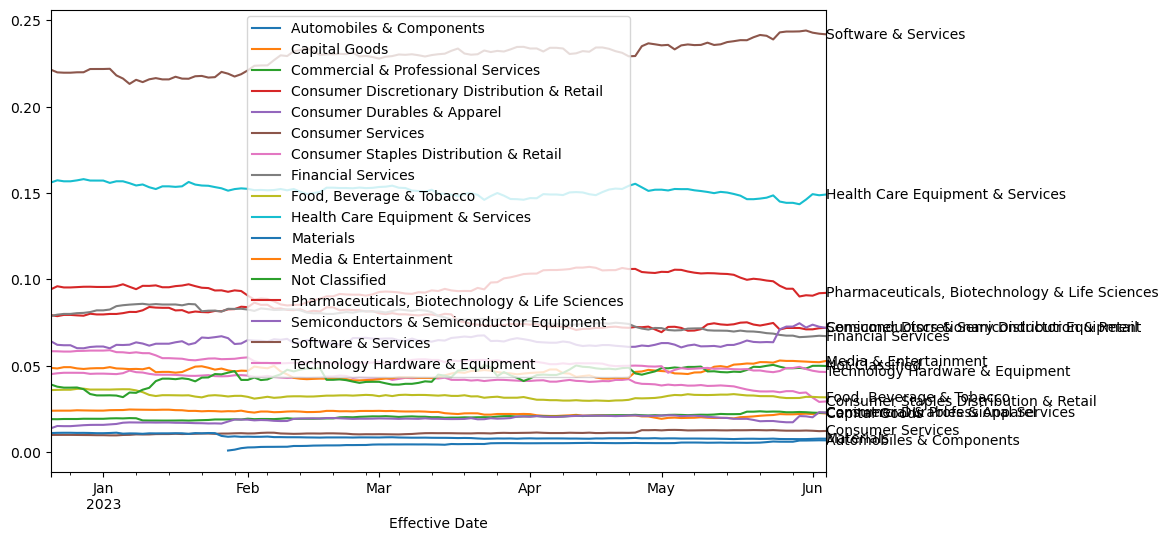

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


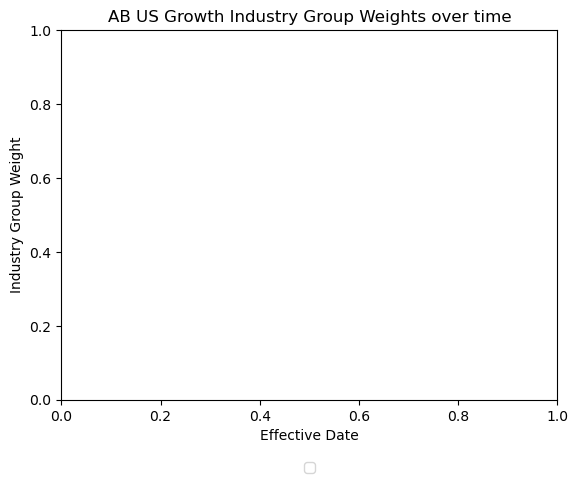

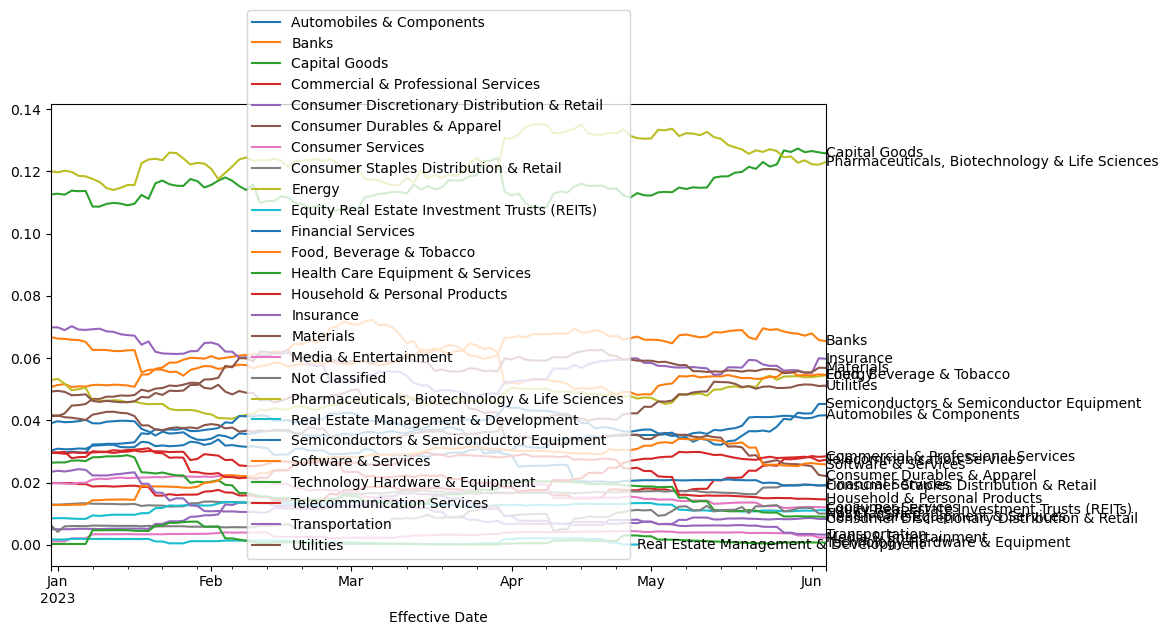

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


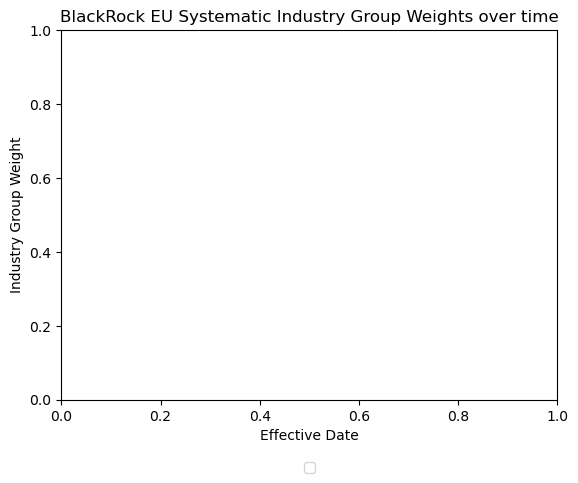

In [8]:
plot_industry_group_weights(industry_weights_df, efm_dict, output_path)

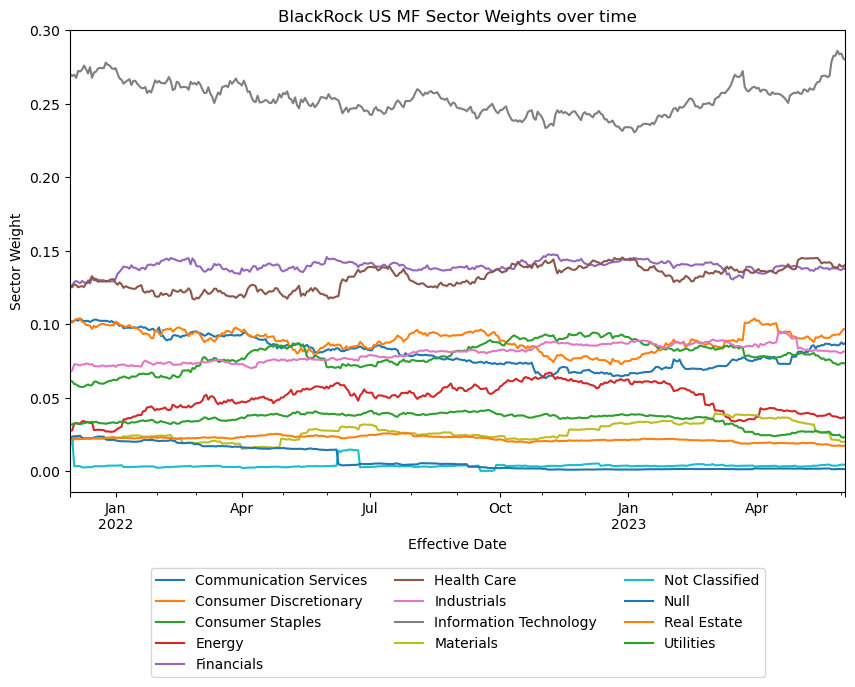

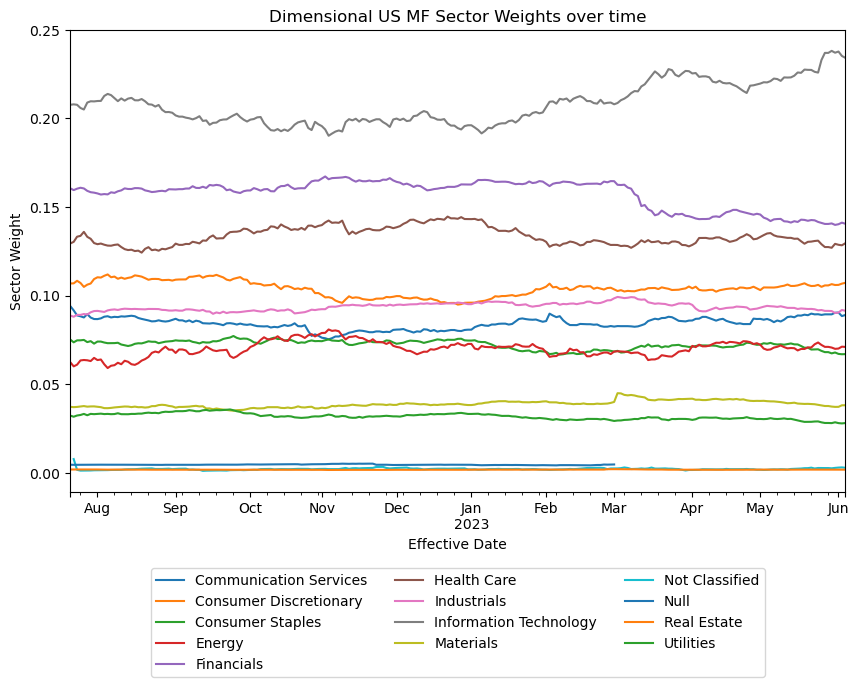

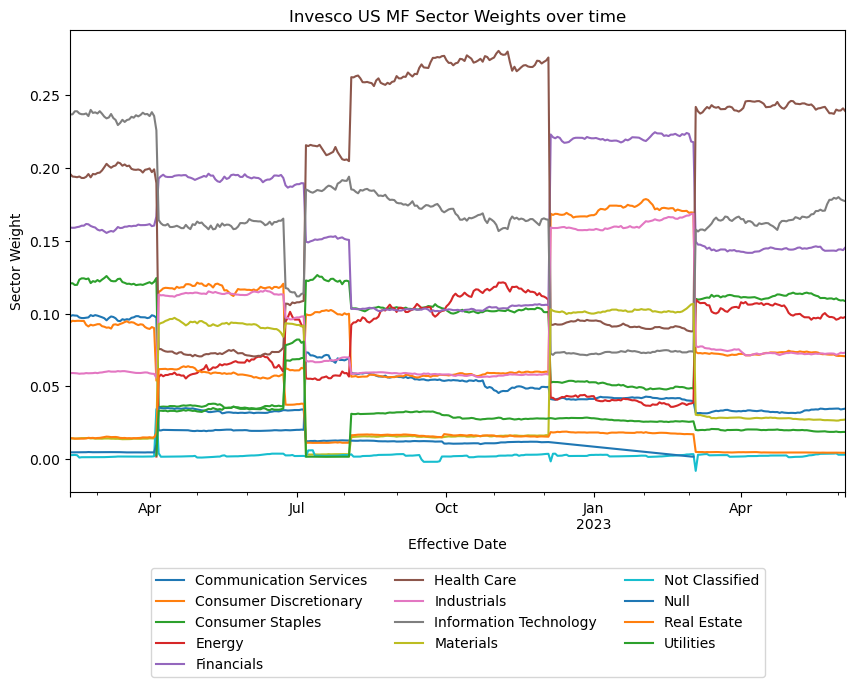

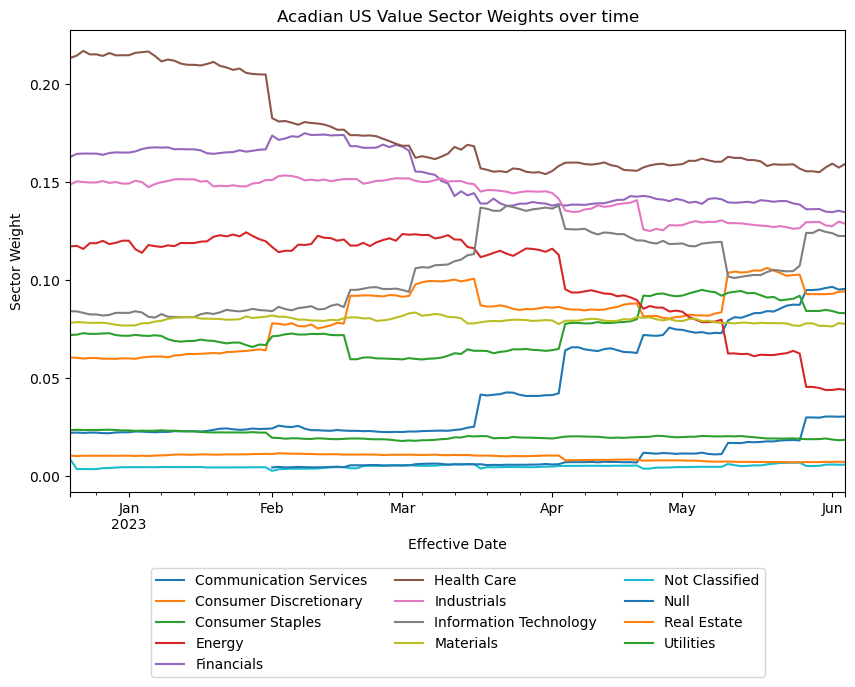

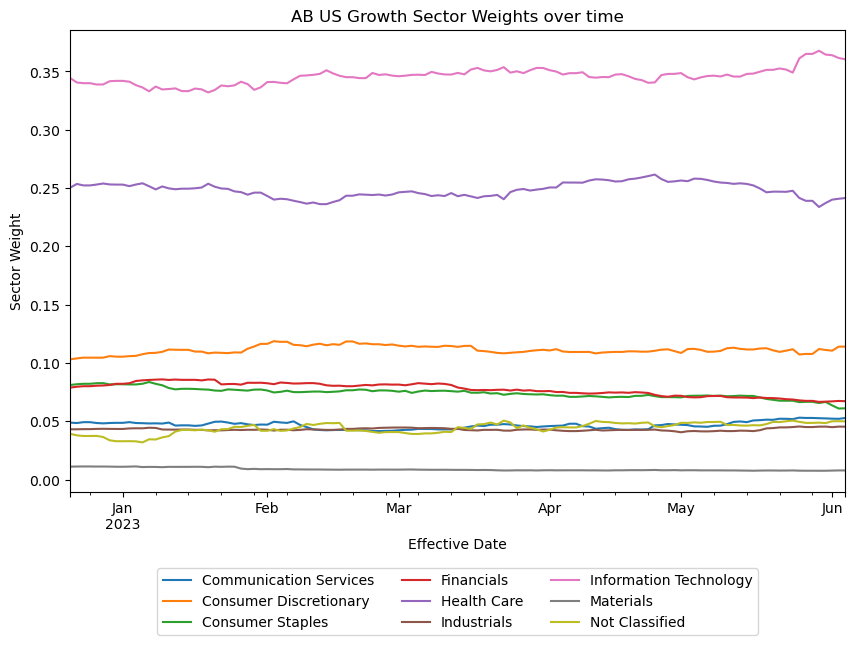

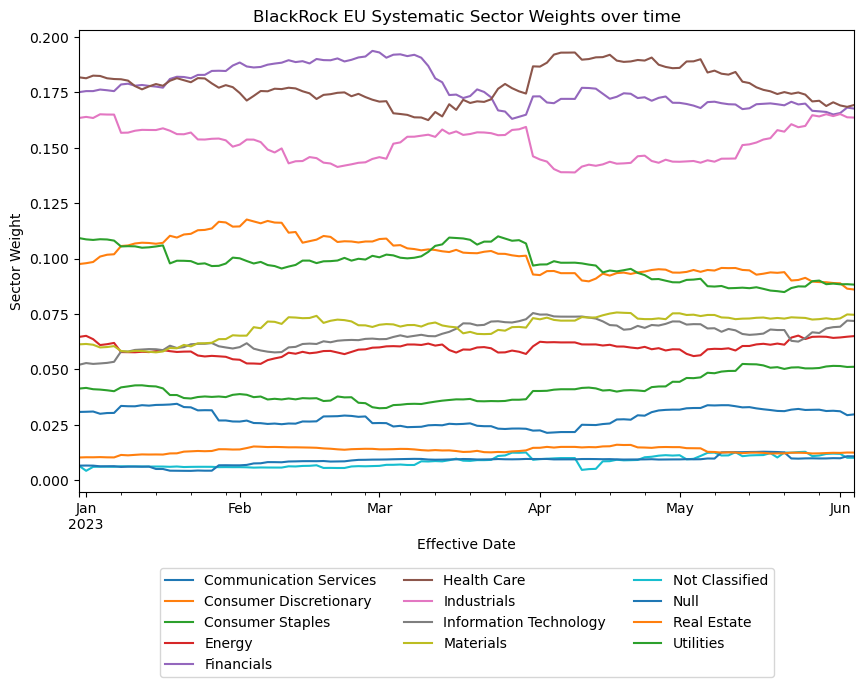

In [10]:
# Calculate sector weights for each day, save into .csv file in output
sector_weights_df = sector_weights(holdings)
save_csv(sector_weights_df, output_path, 'holdings_by_sector')

# Plot sector weight changes for each fund, save as .jpgs in output
plot_sector_weights(sector_weights_df, efm_dict, output_path)

## 6. Tabulate Changes for selected windows

In [11]:
change_windows = [1, 7, 30, 60]
df_changes_list = tabulate_changes_all(sector_weights_df, efm_dict, output_path, change_windows)

,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,0.06%,0.06%,0.03%,0.04%,0.07%,0.04%,0.05%
Consumer Discretionary,0.04%,0.05%,-0.02%,0.02%,0.00%,-0.04%,0.01%
Consumer Staples,-0.01%,0.01%,-0.07%,-0.01%,0.02%,-0.02%,-0.01%
Energy,-0.02%,-0.01%,0.07%,-0.04%,nan%,0.03%,0.00%
Financials,-0.06%,-0.06%,0.17%,-0.08%,-0.02%,-0.05%,-0.02%
Health Care,0.13%,0.11%,-0.19%,0.19%,0.06%,0.08%,0.07%
Industrials,-0.04%,-0.05%,0.04%,-0.12%,-0.01%,-0.01%,-0.03%
Information Technology,-0.10%,-0.11%,-0.05%,0.01%,-0.11%,-0.02%,-0.06%
Materials,-0.01%,0.00%,0.02%,-0.04%,-0.00%,-0.01%,-0.01%
Not Classified,0.00%,-0.02%,0.00%,0.00%,-0.01%,-0.00%,-0.00%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,0.14%,-0.01%,0.01%,0.82%,-0.03%,-0.20%,0.12%
Consumer Discretionary,0.49%,0.22%,-0.11%,-0.86%,0.67%,-0.53%,-0.02%
Consumer Staples,-0.16%,-0.18%,-0.19%,-0.89%,-0.53%,0.09%,-0.31%
Energy,-0.14%,-0.11%,0.00%,-1.85%,nan%,0.13%,-0.39%
Financials,-0.06%,-0.05%,0.21%,-0.40%,-0.07%,-0.23%,-0.10%
Health Care,-0.07%,0.05%,0.15%,0.24%,-0.01%,-0.47%,-0.02%
Industrials,-0.04%,-0.04%,0.06%,0.22%,-0.02%,0.38%,0.09%
Information Technology,0.12%,0.12%,-0.09%,1.53%,-0.08%,0.77%,0.40%
Materials,-0.15%,0.01%,0.05%,0.10%,0.02%,0.14%,0.03%
Not Classified,0.06%,0.02%,-0.07%,-0.11%,0.04%,-0.27%,-0.05%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,1.40%,0.51%,0.23%,2.38%,0.96%,0.06%,0.92%
Consumer Discretionary,0.19%,0.27%,-0.24%,1.26%,0.43%,-0.81%,0.18%
Consumer Staples,-0.57%,-0.54%,-0.46%,-0.87%,-1.15%,-0.43%,-0.67%
Energy,-0.49%,-0.32%,-0.86%,-4.28%,nan%,0.49%,-1.09%
Financials,-0.20%,-0.66%,0.10%,-0.79%,-0.70%,-0.51%,-0.46%
Health Care,0.16%,-0.40%,-0.63%,0.08%,-1.88%,-2.01%,-0.78%
Industrials,-1.29%,-0.21%,0.12%,0.37%,0.27%,1.72%,0.16%
Information Technology,2.72%,1.88%,1.97%,0.34%,2.02%,0.31%,1.54%
Materials,-1.65%,-0.33%,-0.09%,-0.34%,-0.03%,0.20%,-0.37%
Not Classified,0.10%,0.08%,0.06%,0.20%,0.10%,-0.02%,0.08%


,BlackRock US MF,Dimensional US MF,Invesco US MF,Acadian US Value,AB US Growth,BlackRock EU Systematic,Average
Communication Services,1.52%,0.58%,0.29%,7.21%,0.98%,0.48%,1.84%
Consumer Discretionary,0.83%,0.37%,-0.17%,-0.60%,-0.05%,-1.78%,-0.23%
Consumer Staples,-1.20%,-0.47%,-0.23%,2.05%,-1.47%,-1.75%,-0.51%
Energy,-0.02%,0.42%,-0.80%,-7.68%,nan%,0.43%,-1.53%
Financials,0.37%,-1.00%,0.00%,-0.83%,-1.39%,-1.37%,-0.70%
Health Care,0.13%,-0.17%,-0.18%,-0.86%,-0.43%,0.32%,-0.20%
Industrials,-0.68%,-0.63%,-0.28%,-2.18%,0.19%,0.87%,-0.45%
Information Technology,2.10%,1.62%,1.71%,1.29%,1.31%,0.69%,1.45%
Materials,-1.86%,-0.47%,-0.19%,-0.35%,-0.05%,0.35%,-0.43%
Not Classified,0.07%,0.04%,0.05%,-0.02%,0.92%,0.15%,0.20%


## 7. Calculate Top Holdings Changes

In [12]:
change_windows = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                  21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
holdings_changes_dict = holdings_changes(holdings, change_windows)
top_holdings_changes_dict = top_holdings_changes(holdings_changes_dict)
top_holdings_dashboard_dict = top_holdings_dashboard(top_holdings_changes_dict, efm_dict)

NameError: name 'holdings_changes' is not defined

In [ ]:
change_windows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                  11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                  21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

holdings_changes_dict = stock_changes(holdings, change_windows)
holdings_changes_df = stock_changes_df(holdings_changes_dict, efm_dict)
holdings_changes_df.to_csv('holdings_changes_df_6.csv')

In [ ]:
holdings_changes_df

In [ ]:
ema_dict = holdings_ema(holdings_changes_df)
ema_dict

In [ ]:
# Calculate the exponential moving average for each SEDOL across the 30 windows
ema = holdings_changes_df.groupby('SEDOL')['Quantity % Change'].apply(lambda x: x.ewm(span=30).mean())

# Create a new DataFrame with the unique SEDOLs and their respective 30-day EMAs
df_ema = pd.DataFrame({'30-Day EMA': ema})
df_ema.index.name = 'SEDOL'

df_ema